### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

In [2]:
ls /mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/final-runs-test/nih_us_cvd/2023_12_18_15_45_33/count_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
deaths.csv                       state_person_time.csv
healthcare_visits.csv            transition_count.csv
intervention_person_time.csv     ylds.csv
ldlc_medication_person_time.csv  ylls.csv


In [3]:
sim_results_dir = '/mnt/team/simulation_science/pub/models/vivarium_nih_us_cvd/results/final-runs-test/nih_us_cvd/2023_12_18_15_45_33/count_data'

## Checking Stability of Risks over Time

In [4]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year','input_draw','scenario','location']).ptvalue.sum().reset_index()
per_time_group.head()

,age,sex,year,input_draw,scenario,location,ptvalue
0,25_to_29,Female,2021,829,baseline,alabama,3832.914442
1,25_to_29,Female,2021,829,baseline,alaska,3816.739220
2,25_to_29,Female,2021,829,baseline,arizona,3893.552361
3,25_to_29,Female,2021,829,baseline,arkansas,3723.214237
4,25_to_29,Female,2021,829,baseline,california,4161.861739


### BMI

In [5]:
risk_exp = pd.read_csv(sim_results_dir + '/risk_exposure_time.csv')
risk_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,location,age,value
0,0,Female,2021,high_body_mass_index_in_adults,risk_exposure_time,829,baseline,alabama,25_to_29,118281.222950
1,1,Female,2021,high_body_mass_index_in_adults,risk_exposure_time,829,baseline,alaska,25_to_29,110432.273653
2,2,Female,2021,high_body_mass_index_in_adults,risk_exposure_time,829,baseline,arizona,25_to_29,113832.634417
3,3,Female,2021,high_body_mass_index_in_adults,risk_exposure_time,829,baseline,arkansas,25_to_29,115455.912219
4,4,Female,2021,high_body_mass_index_in_adults,risk_exposure_time,829,baseline,california,25_to_29,117290.740241


In [6]:
bmi_exp = risk_exp.loc[risk_exp['risk']=='high_body_mass_index_in_adults']
bmi_exp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,location,age,value
0,0,Female,2021,high_body_mass_index_in_adults,risk_exposure_time,829,baseline,alabama,25_to_29,118281.222950
1,1,Female,2021,high_body_mass_index_in_adults,risk_exposure_time,829,baseline,alaska,25_to_29,110432.273653
2,2,Female,2021,high_body_mass_index_in_adults,risk_exposure_time,829,baseline,arizona,25_to_29,113832.634417
3,3,Female,2021,high_body_mass_index_in_adults,risk_exposure_time,829,baseline,arkansas,25_to_29,115455.912219
4,4,Female,2021,high_body_mass_index_in_adults,risk_exposure_time,829,baseline,california,25_to_29,117290.740241


In [7]:
bmi_exp_rate = bmi_exp.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
bmi_exp_rate = bmi_exp_rate.merge(per_time_group[['age','sex','year','input_draw','scenario','location','ptvalue']],on=['age','sex','year','input_draw','scenario','location'])
#bmi_exp_rate = pd.concat([bmi_exp_rate, per_time_group.ptvalue], axis=1)
bmi_exp_rate['bmi_rate'] = bmi_exp_rate['value'] / bmi_exp_rate['ptvalue']
bmi_exp_rate_summ = (bmi_exp_rate
                .groupby(['age', 'sex', 'year','scenario','location'])
                .bmi_rate.describe(percentiles=[.025,0.5, .975])
                .filter(['mean', '50%','2.5%', '97.5%'])
                .reset_index())
bmi_exp_rate_summ.head()

,age,sex,year,scenario,location,mean,50%,2.5%,97.5%
0,25_to_29,Female,2021,baseline,alabama,30.859343,30.859343,30.859343,30.859343
1,25_to_29,Female,2021,baseline,alaska,28.933670,28.933670,28.933670,28.933670
2,25_to_29,Female,2021,baseline,arizona,29.236189,29.236189,29.236189,29.236189
3,25_to_29,Female,2021,baseline,arkansas,31.009742,31.009742,31.009742,31.009742
4,25_to_29,Female,2021,baseline,california,28.182277,28.182277,28.182277,28.182277


As expected, lifestyle is the only scenario with a real change in BMI. This is good as it is the only one that directly affects BMI and nothing is correlated yet! 

### SBP 

In [9]:
sbp_exp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp_exp_rate = sbp_exp.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
sbp_exp_rate = pd.concat([sbp_exp_rate, per_time_group.ptvalue], axis=1)
sbp_exp_rate['sbp_rate'] = sbp_exp_rate['value'] / sbp_exp_rate['ptvalue']
sbp_exp_rate_summ = (sbp_exp_rate
                .groupby(['age', 'sex', 'year','scenario','location'])
                .sbp_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
sbp_exp_rate_summ.head()

,age,sex,year,scenario,location,mean,2.5%,97.5%
0,25_to_29,Female,2021,baseline,alabama,109.206652,109.206652,109.206652
1,25_to_29,Female,2021,baseline,alaska,110.656577,110.656577,110.656577
2,25_to_29,Female,2021,baseline,arizona,109.121221,109.121221,109.121221
3,25_to_29,Female,2021,baseline,arkansas,110.430772,110.430772,110.430772
4,25_to_29,Female,2021,baseline,california,108.794360,108.794360,108.794360


Polypill and outreach have a visible impact on SBP as expected. Lifestyle has a slight effect as expected. 

### LDL-C

In [11]:
ldl_exp = risk_exp.loc[risk_exp['risk']=='high_ldl_cholesterol']
ldl_exp_rate = ldl_exp.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
ldl_exp_rate = pd.concat([ldl_exp_rate, per_time_group.ptvalue], axis=1)
ldl_exp_rate['ldl_rate'] = ldl_exp_rate['value'] / ldl_exp_rate['ptvalue']
ldl_exp_rate_summ = (ldl_exp_rate
                .groupby(['age', 'sex', 'year','scenario','location'])
                .ldl_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
ldl_exp_rate_summ.head()

,age,sex,year,scenario,location,mean,2.5%,97.5%
0,25_to_29,Female,2021,baseline,alabama,2.582474,2.582474,2.582474
1,25_to_29,Female,2021,baseline,alaska,2.709023,2.709023,2.709023
2,25_to_29,Female,2021,baseline,arizona,2.473958,2.473958,2.473958
3,25_to_29,Female,2021,baseline,arkansas,2.475711,2.475711,2.475711
4,25_to_29,Female,2021,baseline,california,2.624804,2.624804,2.624804


Outreach has the biggest impact. This makes sense with the not yet fixed issues of LDL meds in older adults. Should recheck once those are fixed. 

### FPG

In [ ]:
fpg_exp = risk_exp.loc[risk_exp['risk']=='high_fasting_plasma_glucose']
fpg_exp_rate = fpg_exp.groupby(['age','sex','year','input_draw','scenario','location']).value.sum().reset_index()
fpg_exp_rate = pd.concat([fpg_exp_rate, per_time_group.ptvalue], axis=1)
fpg_exp_rate['fpg_rate'] = fpg_exp_rate['value'] / fpg_exp_rate['ptvalue']
fpg_exp_rate_summ = (fpg_exp_rate
                .groupby(['age', 'sex', 'year','scenario','location'])
                .fpg_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
fpg_exp_rate_summ.head()

In [ ]:
#%%capture
for location in fpg_exp_rate_summ.location.unique():
    for sex in fpg_exp_rate_summ.sex.unique():
        for age in fpg_exp_rate_summ.age.unique():
            plt.figure() 
            subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.location==location) & (fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='baseline')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.location==location) & (fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='lifestyle_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.location==location) & (fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='outreach_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            subdata = fpg_exp_rate_summ.loc[(fpg_exp_rate_summ.location==location) & (fpg_exp_rate_summ.sex==sex) & (fpg_exp_rate_summ.age==age) & (fpg_exp_rate_summ.scenario=='polypill_100')]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.legend(['Baseline','Baseline 95%','Lifestyle','Lifestyle 95%','Outreach','Outreach 95%','Polypill','Polypill 95%'])
            plt.title(f'FPG Exposure: {location} in {sex} {age}') 
            plt.xticks(rotation=90) 
            #plt.ylim(0,100000)
            plt.grid()
            plt.savefig('fpg_exp_8_7_2023.pdf', format='pdf')

Very modest improvments for lifestyle intervention. 

## Comparison to Artifacts

In [15]:
ls /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613

a.hdf                     logs/               oklahoma.hdf
alabama.hdf               louisiana.hdf       oregon.hdf
alaska.hdf                maine.hdf           paf-calculations/
arizona.hdf               maryland.hdf        pennsylvania.hdf
arkansas.hdf              massachusetts.hdf   rhode_island.hdf
california.hdf            michigan.hdf        south_carolina.hdf
colorado.hdf              minnesota.hdf       south_dakota.hdf
connecticut.hdf           mississippi.hdf     south_dakotatennessee.hdf
delaware.hdf              missouri.hdf        tennessee.hdf
district_of_columbia.hdf  montana.hdf         texas.hdf
florida.hdf               nebraska.hdf        utah.hdf
georgia.hdf               nevada.hdf          vermont.hdf
hawaii.hdf                new_hampshire.hdf   virginia.hdf
idaho.hdf                 new_jersey.hdf      washington.hdf
illinois.hdf              new_mexico.hdf      west_virginia.hdf
indiana.hdf               new_york.hdf        wisconsin.hdf
iowa.hdf             

In [16]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [17]:
#art.keys

In [18]:
locations = risk_exp.location.unique()

In [19]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in locations: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/51-locations/v1-20230613/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        #data = data[['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_949']]

        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.5, 0.975], axis=1).filter(['mean', '50%', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i#.capitalize()
        data['measure'] = measure
        #data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

### BMI

In [20]:
bmi_art = load_artifact_data('risk_factor', 'high_body_mass_index_in_adults', 'exposure')
bmi_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_art.age_start,bmi_art.age_end)]
bmi_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,29.033412,29.033224,28.757366,29.300440,washington,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,29.632278,29.631791,29.332102,29.905088,washington,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,29.949943,29.951277,29.684073,30.227876,washington,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,30.112389,30.112918,29.850097,30.399662,washington,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,30.238533,30.235057,29.936267,30.522230,washington,exposure,45_to_49


### SBP

In [22]:
sbp_art = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'exposure')
sbp_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_art.age_start,sbp_art.age_end)]
sbp_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,109.038118,109.062796,106.405986,111.725097,washington,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,111.225071,111.256994,108.811490,113.590849,washington,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,113.783436,113.782741,111.085901,116.355446,washington,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,115.639212,115.571440,113.099469,118.525573,washington,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,118.694697,118.645973,116.152041,121.444385,washington,exposure,45_to_49


### LDL-C

In [24]:
ldl_art = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'exposure')
ldl_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_art.age_start,ldl_art.age_end)]
ldl_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,2.653726,2.652674,2.501467,2.832722,washington,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,2.722218,2.720300,2.564508,2.893812,washington,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,2.845212,2.846297,2.685848,3.008155,washington,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,2.886024,2.886978,2.722389,3.045544,washington,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,3.017583,3.018424,2.840927,3.188939,washington,exposure,45_to_49


### FPG

In [26]:
fpg_art = load_artifact_data('risk_factor', 'high_fasting_plasma_glucose', 'exposure')
fpg_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_art.age_start,fpg_art.age_end)]
fpg_art.head()

,sex,age_start,age_end,year_start,year_end,parameter,mean,50%,2.5%,97.5%,location,measure,age_group
0,Female,25.0,30.0,2019,2020,continuous,5.269120,5.252123,4.547909,6.017223,washington,exposure,25_to_29
1,Female,30.0,35.0,2019,2020,continuous,5.436337,5.431789,4.784969,6.196334,washington,exposure,30_to_34
2,Female,35.0,40.0,2019,2020,continuous,5.519157,5.495740,4.721254,6.442020,washington,exposure,35_to_39
3,Female,40.0,45.0,2019,2020,continuous,5.593661,5.578179,4.811193,6.427358,washington,exposure,40_to_44
4,Female,45.0,50.0,2019,2020,continuous,5.732924,5.725901,4.948982,6.575077,washington,exposure,45_to_49


Very interestingly (and almost worse overall) FPG is working great while the other 3 are looking bad

# SBP Medications

In [28]:
meds = pd.read_csv(sim_results_dir + '/sbp_medication_person_time.csv')
meds.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,medication_adherence,sbp_medication,value,location
0,0,Female,2021,sbp_medication_person_time,829,baseline,25_to_29,primary_non_adherent,no_treatment,287.091034,washington
1,1,Female,2021,sbp_medication_person_time,829,lifestyle_100,25_to_29,primary_non_adherent,no_treatment,287.091034,washington
2,2,Female,2021,sbp_medication_person_time,829,outreach_100,25_to_29,primary_non_adherent,no_treatment,287.091034,washington
3,3,Female,2021,sbp_medication_person_time,829,polypill_100,25_to_29,primary_non_adherent,no_treatment,287.091034,washington
4,4,Female,2021,sbp_medication_person_time,829,baseline,25_to_29,secondary_non_adherent,no_treatment,160.908966,washington


In [29]:
meds_adherent = meds.loc[meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw','scenario','location']], on=['sex','age','year','input_draw','scenario','location'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['sex', 'year', 'sbp_medication','scenario','location'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

,sex,year,sbp_medication,scenario,location,mean,2.5%,97.5%
0,Female,2021,no_treatment,baseline,alabama,0.351777,0.111114,0.648516
1,Female,2021,no_treatment,baseline,alaska,0.367582,0.055435,0.656099
2,Female,2021,no_treatment,baseline,arizona,0.365482,0.083988,0.663597
3,Female,2021,no_treatment,baseline,arkansas,0.364357,0.106848,0.665775
...,...,...,...,...,...,...,...,...
57116,Male,2040,two_drug_std_dose_efficacy,polypill_100,washington,0.000055,0.000000,0.000534
57117,Male,2040,two_drug_std_dose_efficacy,polypill_100,west_virginia,0.000050,0.000000,0.000484
57118,Male,2040,two_drug_std_dose_efficacy,polypill_100,wisconsin,0.000000,0.000000,0.000000
57119,Male,2040,two_drug_std_dose_efficacy,polypill_100,wyoming,0.000000,0.000000,0.000000


In [30]:
%%capture
for location in meds_adherent_rate_summ.location.unique():
    for sex in meds_adherent_rate_summ.sex.unique():
        for scenario in meds_adherent_rate_summ.scenario.unique(): 
            plt.figure() 
            no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.sbp_medication=='no_treatment')]
            plt.plot(no_trt['year'], no_trt['mean'], marker='o')
            #plt.fill_between(no_trt['year'], no_trt['2.5%'], no_trt['97.5%'], alpha=.3)
            one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.sbp_medication=='one_drug_half_dose_efficacy')]
            plt.plot(one_half['year'], one_half['mean'], marker='o')
            #plt.fill_between(one_half['year'], one_half['2.5%'], one_half['97.5%'], alpha=.3)
            one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.sbp_medication=='one_drug_std_dose_efficacy')]
            plt.plot(one_std['year'], one_std['mean'], marker='o')
            #plt.fill_between(one_std['year'], one_std['2.5%'], one_std['97.5%'], alpha=.3)
            two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.sbp_medication=='two_drug_half_dose_efficacy')]
            plt.plot(two_half['year'], two_half['mean'], marker='o')
            #plt.fill_between(two_half['year'], two_half['2.5%'], two_half['97.5%'], alpha=.3)
            two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.sbp_medication=='two_drug_std_dose_efficacy')]
            plt.plot(two_std['year'], two_std['mean'], marker='o')
            #plt.fill_between(two_std['year'], two_std['2.5%'], two_std['97.5%'], alpha=.3)
            three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.sbp_medication=='three_drug_half_dose_efficacy')]
            plt.plot(three_half['year'], three_half['mean'], marker='o')
            #plt.fill_between(three_half['year'], three_half['2.5%'], three_half['97.5%'], alpha=.3)
            three_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.sbp_medication=='three_drug_std_dose_efficacy')]
            plt.plot(three_std['year'], three_std['mean'], marker='o')
            #plt.fill_between(three_std['year'], three_std['2.5%'], three_std['97.5%'], alpha=.3)
            plt.title(f'Medications: {sex} and {location} in {scenario}') 
            plt.xticks(rotation=90)
            plt.legend(['No Treatment', 'One Drug at Half Dose','One Drug at Std Dose','Two Drug at Half Dose','Two Drug at Std Dose','Three Drug at Half Dose','Three Drug at Std Dose'],loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            plt.savefig('sbp_meds_8_7_2023.pdf', format='pdf')

In [31]:
ldl_meds = pd.read_csv(sim_results_dir + '/ldlc_medication_person_time.csv')
ldl_meds.head()

,Unnamed: 0,sex,year,measure,input_draw,scenario,age,medication_adherence,ldlc_medication,value,location
0,0,Female,2021,ldlc_medication_person_time,829,baseline,25_to_29,primary_non_adherent,high_intensity,0.0,washington
1,1,Female,2021,ldlc_medication_person_time,829,lifestyle_100,25_to_29,primary_non_adherent,high_intensity,0.0,washington
2,2,Female,2021,ldlc_medication_person_time,829,outreach_100,25_to_29,primary_non_adherent,high_intensity,0.0,washington
3,3,Female,2021,ldlc_medication_person_time,829,polypill_100,25_to_29,primary_non_adherent,high_intensity,0.0,washington
4,4,Female,2021,ldlc_medication_person_time,829,baseline,25_to_29,secondary_non_adherent,high_intensity,0.0,washington


In [32]:
meds_adherent = ldl_meds.loc[ldl_meds['medication_adherence']=='adherent'].reset_index()
meds_adherent_rate = meds_adherent.merge(per_time_group[['ptvalue','sex','age','year','input_draw','scenario','location']], on=['sex','age','year','input_draw','scenario','location'])
meds_adherent_rate['meds_adherent_rate'] = meds_adherent_rate['value'] / meds_adherent_rate['ptvalue']
meds_adherent_rate_summ = (meds_adherent_rate
                .groupby(['sex', 'year', 'ldlc_medication','scenario','location'])
                .meds_adherent_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
meds_adherent_rate_summ

,sex,year,ldlc_medication,scenario,location,mean,2.5%,97.5%
0,Female,2021,high_intensity,baseline,alabama,0.053666,0.008179,0.130017
1,Female,2021,high_intensity,baseline,alaska,0.046343,0.007490,0.103780
2,Female,2021,high_intensity,baseline,arizona,0.049031,0.006606,0.109896
3,Female,2021,high_intensity,baseline,arkansas,0.048788,0.012036,0.114940
...,...,...,...,...,...,...,...,...
48956,Male,2040,no_treatment,polypill_100,washington,0.440699,0.136637,0.632210
48957,Male,2040,no_treatment,polypill_100,west_virginia,0.449447,0.166136,0.632333
48958,Male,2040,no_treatment,polypill_100,wisconsin,0.438563,0.108572,0.642218
48959,Male,2040,no_treatment,polypill_100,wyoming,0.441029,0.130139,0.635467


In [33]:
%%capture
for location in meds_adherent_rate_summ.location.unique():
    for sex in meds_adherent_rate_summ.sex.unique():
        for scenario in meds_adherent_rate_summ.scenario.unique():
            plt.figure() 
            no_trt = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.ldlc_medication=='no_treatment')]
            plt.plot(no_trt['year'], no_trt['mean'], marker='o')
            #plt.fill_between(no_trt['year'], no_trt['2.5%'], no_trt['97.5%'], alpha=.3)
            one_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.ldlc_medication=='low_intensity')]
            plt.plot(one_half['year'], one_half['mean'], marker='o')
            #plt.fill_between(one_half['year'], one_half['2.5%'], one_half['97.5%'], alpha=.3)
            one_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.ldlc_medication=='medium_intensity')]
            plt.plot(one_std['year'], one_std['mean'], marker='o')
            #plt.fill_between(one_std['year'], one_std['2.5%'], one_std['97.5%'], alpha=.3)
            two_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.ldlc_medication=='high_intensity')]
            plt.plot(two_half['year'], two_half['mean'], marker='o')
            #plt.fill_between(two_half['year'], two_half['2.5%'], two_half['97.5%'], alpha=.3)
            two_std = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.ldlc_medication=='low_med_with_eze')]
            plt.plot(two_std['year'], two_std['mean'], marker='o')
            #plt.fill_between(two_std['year'], two_std['2.5%'], two_std['97.5%'], alpha=.3)
            three_half = meds_adherent_rate_summ.loc[(meds_adherent_rate_summ.location==location) & (meds_adherent_rate_summ.sex==sex) & (meds_adherent_rate_summ.scenario==scenario) & (meds_adherent_rate_summ.ldlc_medication=='high_with_eze')]
            plt.plot(three_half['year'], three_half['mean'], marker='o')
            #plt.fill_between(three_half['year'], three_half['2.5%'], three_half['97.5%'], alpha=.3)
            plt.title(f'Medications: {sex} and {location} in {scenario}') 
            plt.xticks(rotation=90)
            plt.legend(['No Treatment','Low Intensity','Medium Intensity','High Intensity','Low/Med Intensity with Eze','High Intensity with Eze'],loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            plt.savefig('ldl_meds_8_7_2023.pdf', format='pdf')

The outreach looks funny - the no treatment group increases? Need to investigate further 

## Time in Interventions 

In [34]:
intervention = pd.read_csv(sim_results_dir + '/intervention_person_time.csv')
print(intervention.intervention_type.unique())
print(intervention.scenario.unique())

['lifestyle' 'outreach' 'polypill']
['baseline' 'lifestyle_100' 'outreach_100' 'polypill_100']


In [35]:
outreach = intervention.loc[(intervention.intervention == 'yes') & (intervention.intervention_type == 'outreach')]
outreach = (outreach
                .groupby(['age', 'sex', 'year','scenario','location'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

outreach.head()

,age,sex,year,scenario,location,mean,2.5%,97.5%
0,25_to_29,Female,2021,baseline,alabama,0.0,0.0,0.0
1,25_to_29,Female,2021,baseline,alaska,0.0,0.0,0.0
2,25_to_29,Female,2021,baseline,arizona,0.0,0.0,0.0
3,25_to_29,Female,2021,baseline,arkansas,0.0,0.0,0.0
4,25_to_29,Female,2021,baseline,california,0.0,0.0,0.0


In [37]:
polypill = intervention.loc[(intervention.intervention == 'yes') & (intervention.intervention_type == 'polypill')]
polypill = (polypill
                .groupby(['age', 'sex', 'year','scenario','location'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

polypill.head()

,age,sex,year,scenario,location,mean,2.5%,97.5%
0,25_to_29,Female,2021,baseline,alabama,0.0,0.0,0.0
1,25_to_29,Female,2021,baseline,alaska,0.0,0.0,0.0
2,25_to_29,Female,2021,baseline,arizona,0.0,0.0,0.0
3,25_to_29,Female,2021,baseline,arkansas,0.0,0.0,0.0
4,25_to_29,Female,2021,baseline,california,0.0,0.0,0.0


NameError: name 'pdf' is not defined

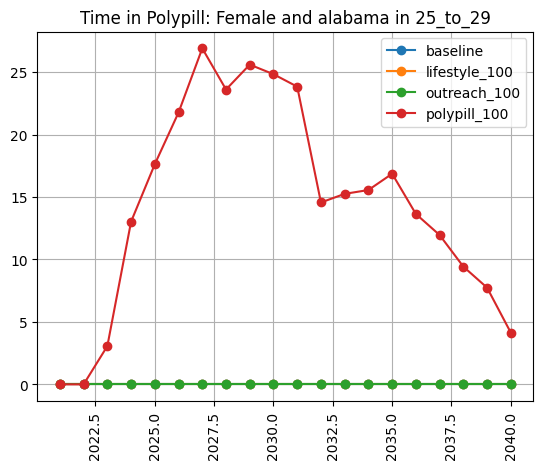

In [38]:
for location in polypill.location.unique():
    for sex in polypill.sex.unique():
        for age in polypill.age.unique():
            plt.figure() 
            subdata = polypill.loc[(polypill.location==location) & (polypill.sex==sex) & (polypill.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Time in Polypill: {sex} and {location} in {age}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [ ]:
intervention.intervention_type.unique()

In [ ]:
lifestyle = intervention.loc[(intervention.intervention == 'yes') & (intervention.intervention_type == 'lifestyle')]
lifestyle = (lifestyle
                .groupby(['age', 'sex', 'year','scenario'])
                .value.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

lifestyle.head()

In [ ]:
with PdfPages('lifestyle_time_model13.pdf') as pdf:
    for sex in lifestyle.sex.unique():
        for age in lifestyle.age.unique():
            plt.figure() 
            subdata = lifestyle.loc[(lifestyle.sex==sex) & (lifestyle.age==age)]
            groups = subdata.groupby('scenario')
            for name, group in groups: 
                plt.plot(group['year'], group['mean'], marker='o', label=name)
                plt.fill_between(group['year'], group['2.5%'], group['97.5%'], alpha=.3)
            plt.legend()
            plt.title(f'Time in Lifestyle: {sex} in {age}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

## Healthcare Visits 

In [ ]:
visits = pd.read_csv(sim_results_dir + '/healthcare_visits.csv')
visits.head()

In [ ]:
screening_art = load_artifact_data('healthcare_entity', 'outpatient_visits', 'outpatient_envelope')
screening_art['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(screening_art.age_start,screening_art.age_end)]
screening_art.head()

In [ ]:
screen = visits.loc[visits['visit_type']=='background'].reset_index()
screen_rate = screen.merge(per_time_group[['ptvalue','sex','age','year','input_draw','scenario']], on=['sex','age','year','input_draw','scenario'])
screen_rate['screen_rate'] = screen_rate['value'] / screen_rate['ptvalue']
screen_rate_summ = (screen_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .screen_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
screen_rate_summ.head()

In [ ]:
#%%capture
for sex in screen_rate_summ.sex.unique():
    for age in screen_rate_summ.age.unique():
        plt.figure() 
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.age==age)&(screen_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.age==age)&(screen_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.age==age)&(screen_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.age==age)&(screen_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Screening Visits: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [ ]:
for sex in screen_rate_summ.sex.unique():
    plt.figure() 
    subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.year==2023) & (screen_rate_summ.scenario=='baseline')]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = screening_art.loc[(screening_art.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Screening Visits in 2023: {sex}') 
    plt.xticks(rotation=90) 
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%'])     
    plt.grid()

In [ ]:
for sex in screen_rate_summ.sex.unique():
    plt.figure() 
    subdata = screen_rate_summ.loc[(screen_rate_summ.sex==sex) & (screen_rate_summ.year==2040) & (screen_rate_summ.scenario=='baseline')]
    plt.plot(subdata['age'], subdata['mean'], marker='o')
    plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
    subdata2 = screening_art.loc[(screening_art.sex==sex)]
    plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
    plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
    plt.title(f'Screening Visits in 2040: {sex}') 
    plt.xticks(rotation=90) 
    plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%'])     
    plt.grid()

In [ ]:
followup = visits.loc[visits['visit_type']=='scheduled'].reset_index()
followup_rate = followup.merge(per_time_group[['ptvalue','sex','age','year','input_draw','scenario']], on=['sex','age','year','input_draw','scenario'])
followup_rate['followup_rate'] = followup_rate['value'] / followup_rate['ptvalue']
followup_rate_summ = (followup_rate
                .groupby(['age', 'sex', 'year','scenario'])
                .followup_rate.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())
followup_rate_summ

In [ ]:
#%%capture
for sex in followup_rate_summ.sex.unique():
    for age in followup_rate_summ.age.unique():
        plt.figure() 
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.age==age) & (followup_rate_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.age==age) & (followup_rate_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.age==age) & (followup_rate_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = followup_rate_summ.loc[(followup_rate_summ.sex==sex) & (followup_rate_summ.age==age) & (followup_rate_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Follow-up Visits: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()

In [ ]:
screen_follow = screen_rate.merge(followup_rate[['followup_rate','sex','age','year','input_draw','scenario']], on=['sex','age','year','input_draw','scenario'])
screen_follow['screen_follow'] = screen_follow['screen_rate'] + screen_follow['followup_rate']
screen_follow_summ = (screen_follow
                .groupby(['age', 'sex', 'year','scenario'])
                .screen_follow.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

screen_follow_summ.head()

In [ ]:
for sex in screen_follow_summ.sex.unique():
    for age in screen_follow_summ.age.unique():
        plt.figure() 
        subdata = screen_follow_summ.loc[(screen_follow_summ.sex==sex) & (screen_follow_summ.age==age) & (screen_follow_summ.scenario=='baseline')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = screen_follow_summ.loc[(screen_follow_summ.sex==sex) & (screen_follow_summ.age==age) & (screen_follow_summ.scenario=='lifestyle_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = screen_follow_summ.loc[(screen_follow_summ.sex==sex) & (screen_follow_summ.age==age) & (screen_follow_summ.scenario=='outreach_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        subdata = screen_follow_summ.loc[(screen_follow_summ.sex==sex) & (screen_follow_summ.age==age) & (screen_follow_summ.scenario=='polypill_100')]
        plt.plot(subdata['year'], subdata['mean'], marker='o')
        plt.legend(['Baseline','Lifestyle','Outreach','Polypill'])
        plt.title(f'Screening and Follow-up Visits: {sex} in {age}') 
        plt.xticks(rotation=90) 
        plt.grid()